## Imports

In [1]:
import logging
import os
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import seaborn as sns
import numpy as np
import imageio
import shutil

sns.set()
sns.set_style('white')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

left_bound = -8
right_bound = 8

### Visualization functions

In [2]:
def get_mesh(left_bound, right_bound, grid_size=100, device=None):
    x = np.linspace(left_bound, right_bound, grid_size)
    y = np.linspace(left_bound, right_bound, grid_size)
    mesh = []
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))
    mesh = np.stack(mesh, axis=0)
    mesh = torch.from_numpy(mesh).float()
    if device is not None:
        mesh = mesh.to(device)
    return mesh

def plot_density(teacher, left_bound, right_bound, ax=None, device=None):
    mesh = get_mesh(left_bound, right_bound, grid_size=100, device=device)
    logp_true = teacher.log_prob(mesh)
    logp_true = logp_true.view(100, 100).exp()

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno', extent=[left_bound, right_bound, left_bound, right_bound])
    ax.set_title('Data density')

def plot_vector_field(scores, mesh_np, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.quiver(mesh_np[:, 0], mesh_np[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax.set_title(title)
    ax.set_aspect('equal')

def plot_scatter(samples, title, left_bound, right_bound, ax=None, s=0.1):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(samples[:, 0], samples[:, 1], s=s)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim([left_bound, right_bound])
    ax.set_ylim([left_bound, right_bound])

### Data distributions

In [3]:
class GMMDist(object):
    def __init__(self, dim):
        self.mix_probs = torch.tensor([0.8, 0.2])
        # self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        # self.mix_probs = torch.tensor([0.1, 0.1, 0.8])
        # self.means = torch.stack([5 * torch.ones(dim), torch.zeros(dim), -torch.ones(dim) * 5], dim=0)
        self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        self.sigma = 1
        self.std = torch.stack([torch.ones(dim) * self.sigma for i in range(len(self.mix_probs))], dim=0)

    def sample(self, n):
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        device = samples.device
        means = self.means.to(device)
        mix_probs = self.mix_probs.to(device)
        logps = []
        for i in range(len(mix_probs)):
            logps.append((-((samples - means[i]) ** 2).sum(dim=-1) / (2 * self.sigma ** 2) - 0.5 * np.log(
                2 * np.pi * self.sigma ** 2)) + mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

In [4]:
class GMMDistAnneal(object):
    def __init__(self, dim):
        self.mix_probs = torch.tensor([0.8, 0.2])
        # self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        # self.mix_probs = torch.tensor([0.1, 0.1, 0.8])
        # self.means = torch.stack([5 * torch.ones(dim), torch.zeros(dim), -torch.ones(dim) * 5], dim=0)
        self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        self.sigma = 1

    def sample(self, n, sigma=1):
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        return torch.randn_like(means) * sigma + means


    def log_prob(self, samples, sigma=1):
        device = samples.device
        means = self.means.to(device)
        mix_probs = self.mix_probs.to(device)
        logps = []
        for i in range(len(mix_probs)):
            logps.append((-((samples - means[i]) ** 2).sum(dim=-1) / (2 * sigma ** 2) - 0.5 * np.log(
                2 * np.pi * sigma ** 2)) + mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

    def score(self, samples, sigma=1):
        with torch.enable_grad():
            samples = samples.detach()
            samples.requires_grad_(True)
            log_probs = self.log_prob(samples, sigma).sum()
            return autograd.grad(log_probs, samples)[0]

## Noise Conditional Score Networks

### Denoising Score Matching (Eq. 2)

The objective function for Denoising Score Matching is given by:

$$J_{DSM}(\theta) = \frac{1}{2} \mathbb{E}_{q_\sigma(\tilde{x}|x)p_{data}(x)} [ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) ||_2^2 ]$$

where $\nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) = \frac{x - \tilde{x}}{\sigma^2}$ for Gaussian noise.

In [5]:
def dsm_score_estimation(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)

    return loss

### Annealed Denoising Score Matching (Eq. 5)

The annealed objective function is:

$$\mathcal{L}(\theta; \{ \sigma_i \}_{i=1}^L) = \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) \mathbb{E}_{p_{data}(x)} \mathbb{E}_{q_{\sigma_i}(\tilde{x}|x)} [ || s_\theta(\tilde{x}, \sigma_i) + \frac{\tilde{x} - x}{\sigma_i^2} ||_2^2 ]$$

where $\lambda(\sigma_i) = \sigma_i^2$.

In [6]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, labels)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power

    return loss.mean(dim=0)

### Langevin Dynamics

The standard Langevin dynamics update rule is:
$$\tilde{x}_t = \tilde{x}_{t-1} + \frac{\epsilon}{2} \nabla_x \log p(\tilde{x}_{t-1}) + \sqrt{\epsilon} z_t$$

In [7]:
def langevin_dynamics(score, init, lr=0.1, step=1000):
    for i in range(step):
        current_lr = lr
        init = init + current_lr / 2 * score(init).detach()
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init

### Annealed Langevin Dynamics (Algorithm 1 & Eq. 4)

**Algorithm 1: Annealed Langevin Dynamics**

1. **Input:** $\{ \sigma_i \}_{i=1}^L, \epsilon, T$
2. **Initialize** $\tilde{x}_0$
3. **For** $i = 1$ **to** $L$ **do**
    * $\alpha_i \leftarrow \epsilon \cdot \sigma_i^2 / \sigma_L^2$
    * **For** $t = 1$ **to** $T$ **do**
        * Draw $z_t \sim \mathcal{N}(0, I)$
        * $\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$
    * **End For**
    * $\tilde{x}_0 \leftarrow \tilde{x}_T$
4. **End For**
5. **Output** $\tilde{x}_T$

The update rule (Eq. 4) is:
$$\tilde{x}_t = \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$$

In [8]:
def anneal_langevin_dynamics(score, init, sigmas, lr=0.1, n_steps_each=100):
    for sigma in sigmas:
        for i in range(n_steps_each):
            current_lr = lr * (sigma / sigmas[-1]) ** 2
            init = init + current_lr / 2 * score(init, sigma).detach()
            init = init + torch.randn_like(init) * torch.sqrt(current_lr)

    return init

### Conditional Score 

The model must be conditioned on the noise level - `ConditionalScoreNet` takes both the data $x$ and the noise level index `labels` as input.
* Learn a function $s_\theta(x, \sigma)$ that can output the correct score for *any* of the trained noise levels.

In [9]:
class ConditionalScoreNet(nn.Module):
    def __init__(self, n_classes, hidden_units=128):
        super().__init__()
        self.embed = nn.Embedding(n_classes, hidden_units)
        self.main = nn.Sequential(
            nn.Linear(2 + hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, 2),
        )

    def forward(self, x, labels):
        embed = self.embed(labels)
        x = torch.cat([x, embed], dim=-1)
        return self.main(x)

## Experiments

### Two Gaussians Dataset

#### Langevin dynamics (single noise scale)

In [10]:
hidden_units = 128
score = nn.Sequential(
    nn.Linear(2, hidden_units),
    nn.Softplus(),
    nn.Linear(hidden_units, hidden_units),
    nn.Softplus(),
    nn.Linear(hidden_units, 2),
)

teacher = GMMDist(dim=2)
optimizer = optim.Adam(score.parameters(), lr=0.001)

for step in range(10000):
    samples = teacher.sample((128,))

    loss = dsm_score_estimation(score, samples, sigma=1.)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    logging.info('step: {}, loss: {}'.format(step, loss.item()))

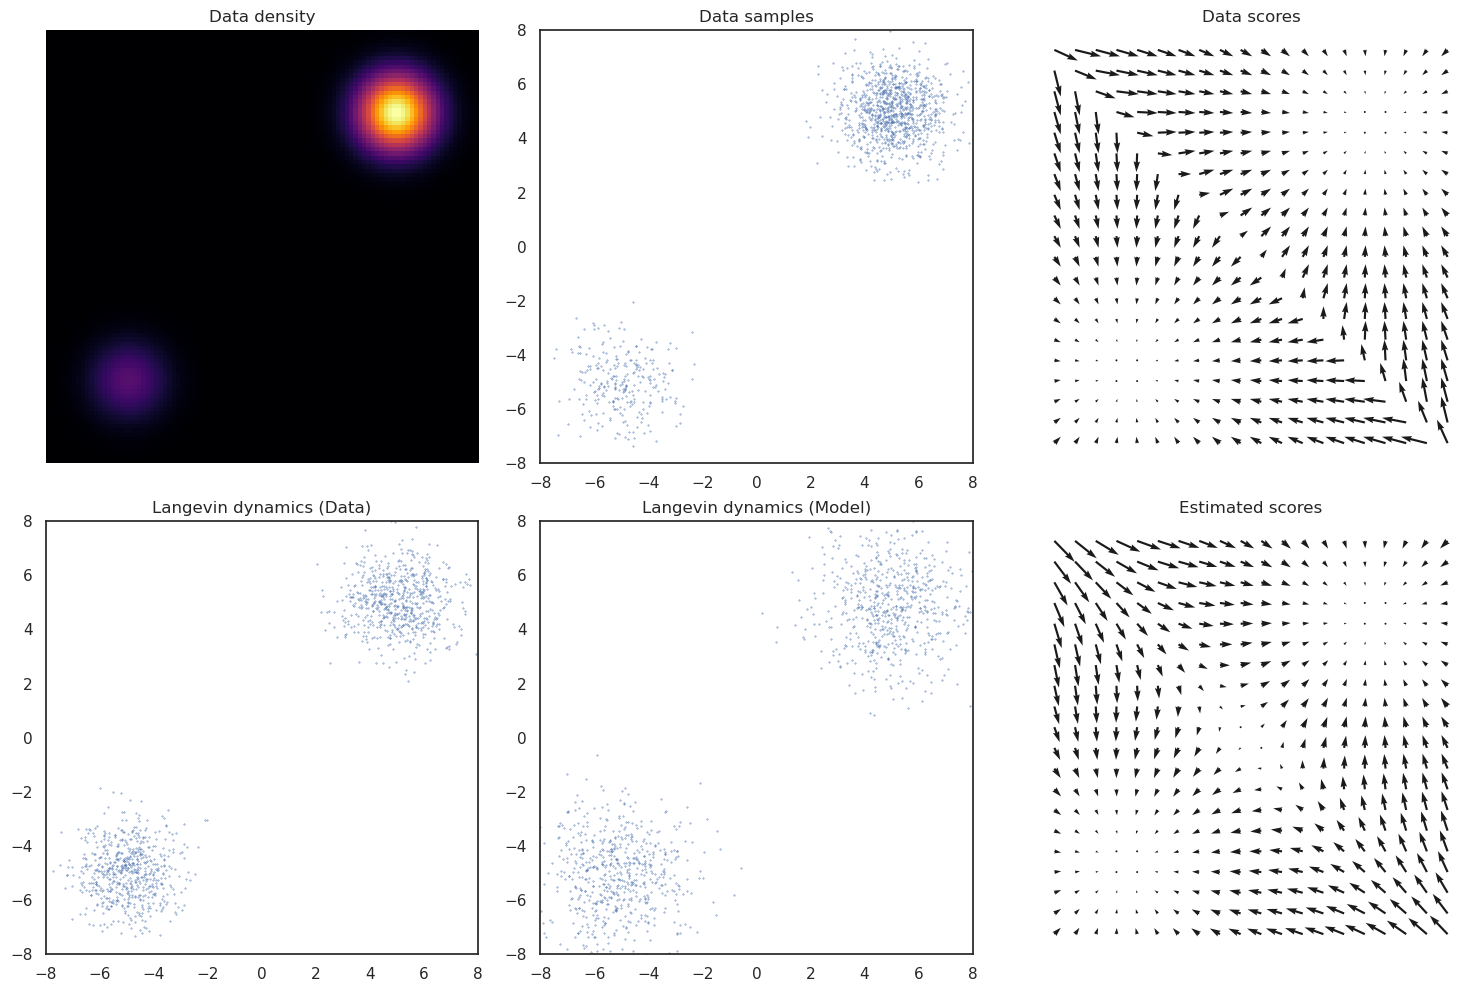

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Prepare mesh for vector fields
mesh = get_mesh(left_bound, right_bound, grid_size=20, device='cpu')
mesh_np = mesh.detach().cpu().numpy()

# 1. Data Density
# Use 'cpu' to match the device of the trained model (which was trained on CPU)
plot_density(teacher, left_bound, right_bound, ax=axes[0], device='cpu')

# 2. Data Samples
samples = teacher.sample((1280,)).detach().cpu().numpy()
plot_scatter(samples, 'Data samples', left_bound, right_bound, ax=axes[1])

# 3. Data Scores (Ground Truth)
def data_score(x):
    x = x.detach()
    x.requires_grad_(True)
    y = teacher.log_prob(x).sum()
    return autograd.grad(y, x)[0]

scores = data_score(mesh).detach().cpu().numpy()
plot_vector_field(scores, mesh_np, 'Data scores', ax=axes[2])

# 4. Langevin Dynamics (Data)
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
samples = langevin_dynamics(data_score, samples).detach().numpy()
plot_scatter(samples, 'Langevin dynamics (Data)', left_bound, right_bound, ax=axes[3])

# 5. Langevin Dynamics (Model)
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
samples = langevin_dynamics(score, samples).detach().numpy()
plot_scatter(samples, 'Langevin dynamics (Model)', left_bound, right_bound, ax=axes[4])

# 6. Estimated Scores
scores = score(mesh.detach()).detach().cpu().numpy()
plot_vector_field(scores, mesh_np, 'Estimated scores', ax=axes[5])

plt.tight_layout()
plt.show()

#### Annealed Langevin dynamics

In [12]:
# Training the Annealed Score Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

teacher_anneal = GMMDistAnneal(dim=2)
# Denser range of sigmas for smoother GIF
sigmas = torch.tensor(np.exp(np.linspace(np.log(20), 0., 50))).float().to(device)

score_anneal = ConditionalScoreNet(n_classes=50, hidden_units=128).to(device)
optimizer_anneal = optim.Adam(score_anneal.parameters(), lr=0.001)

for step in range(10000):
    samples = teacher_anneal.sample((128,)).to(device)
    labels = torch.randint(0, len(sigmas), (128,)).to(device)
    
    loss = anneal_dsm_score_estimation(score_anneal, samples, labels, sigmas)

    optimizer_anneal.zero_grad()
    loss.backward()
    optimizer_anneal.step()

    if step % 1000 == 0:
        logging.info('step: {}, loss: {}'.format(step, loss.item()))

# Wrapper for the trained model to be compatible with visualization
def trained_score_fn(x, sigma):
    # Find the label index corresponding to sigma
    # We assume sigma is one of the values in sigmas
    diff = (sigmas - sigma).abs()
    label = torch.argmin(diff)
    labels = torch.ones(x.shape[0], dtype=torch.long).to(device) * label
    return score_anneal(x, labels)

Using device: cuda


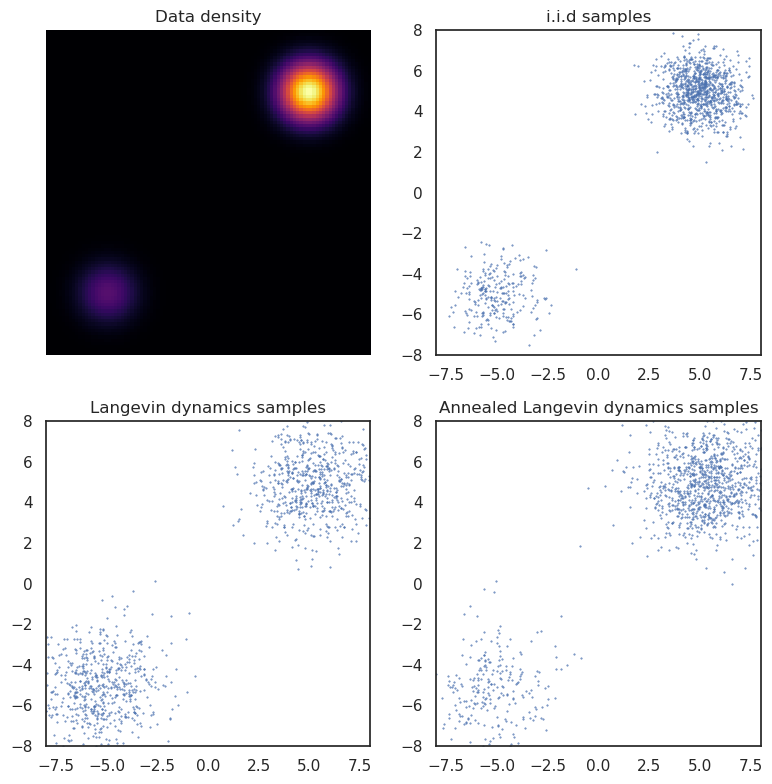

/tmp/ipykernel_236285/2733381646.py:52: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as annealed_scores.gif


In [21]:
sns.set(font_scale=1)
sns.set_style('white')

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

# 1. Data Density
plot_density(teacher, left_bound, right_bound, ax=axes[0], device=device)

# 2. I.I.D Samples
samples = teacher.sample((1280,))
if device is not None:
    samples = samples.to(device)
samples = samples.detach().cpu().numpy()
plot_scatter(samples, 'i.i.d samples', left_bound, right_bound, ax=axes[1], s=0.2)

# 3. Standard Langevin Dynamics Samples (using smallest sigma)
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
if device is not None:
    samples = samples.to(device)
# Use the score function for the smallest sigma (last one)
score_fn_smallest = lambda x: trained_score_fn(x, sigmas[-1])
samples = langevin_dynamics(score_fn_smallest, samples).detach().cpu().numpy()
plot_scatter(samples, 'Langevin dynamics samples', left_bound, right_bound, ax=axes[2], s=0.2)

# 4. Annealed Langevin Dynamics Samples
samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
if device is not None:
    samples = samples.to(device)
samples = anneal_langevin_dynamics(trained_score_fn, samples, sigmas).detach().cpu().numpy()
plot_scatter(samples, 'Annealed Langevin dynamics samples', left_bound, right_bound, ax=axes[3], s=0.2)

plt.tight_layout()
plt.show()

# 5. Visualize scores for different sigmas and create GIF
mesh = get_mesh(left_bound, right_bound, grid_size=20, device=device)
mesh_np = mesh.detach().cpu().numpy()

images = []
if not os.path.exists('tmp_gif'):
    os.makedirs('tmp_gif')

for i, sigma in enumerate(sigmas):
    scores = trained_score_fn(mesh, sigma).detach().cpu().numpy()
    
    fig_gif, ax_gif = plt.subplots()
    plot_vector_field(scores, mesh_np, 'Scores (sigma={:.2f})'.format(sigma), ax=ax_gif)
    filename = f'tmp_gif/sigma_{i}.png'
    fig_gif.savefig(filename)
    plt.close(fig_gif)
    images.append(imageio.imread(filename))

imageio.mimsave('annealed_scores.gif', images, duration=0.2)
print("GIF saved as annealed_scores.gif")

# Clean up tmp files
shutil.rmtree('tmp_gif')

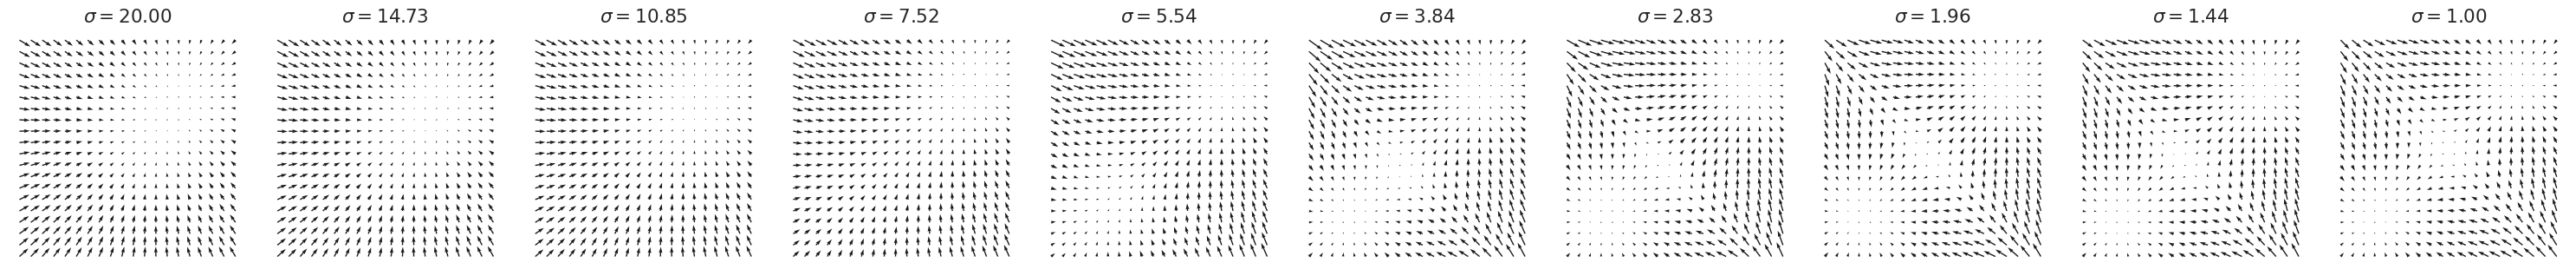

In [18]:
# Visualize scores for 10 different noise scales
fig, axes = plt.subplots(1, 10, figsize=(30, 6))
axes = axes.flatten()

# Select 10 indices from the 50 sigmas
indices = np.linspace(0, len(sigmas) - 1, 10).astype(int)

mesh = get_mesh(left_bound, right_bound, grid_size=20, device=device)
mesh_np = mesh.detach().cpu().numpy()

for i, idx in enumerate(indices):
    sigma = sigmas[idx]
    scores = trained_score_fn(mesh, sigma).detach().cpu().numpy()
    
    plot_vector_field(scores, mesh_np, '$\sigma={:.2f}$'.format(sigma.item()), ax=axes[i])

plt.tight_layout()
plt.show()